# Эксперименты: Статика vs. Динамика

Будем сравнивать производительность трёх алгоритмов, решающих задачу single source shortest path (SSSP):

1. Алгоритм Беллмана-Форда, реализованная при помощи GraphBLAS.
2. Алгоритм Дейкстры.
3. Динамический алгоритм, использующий в основе алгоритм Дейкстры.

Соответсвенно первые 2 алгоритма так называемая **статика**, а последний **динамика**.

## Цель
Хотим определить какой из алгоритмов-участников работает быстрее
- на графах каких размеров
- с каким процентом изменившихся рёбер
- с кикими условиями изменения:
    - только добавление ребер
    - только удаление ребер
    - любые изменения

## Оборудование

In [1]:
import math
!echo '---------------------- CPU ----------------------'
!lscpu | grep 'Model name'
!echo '-------------------- PYTHON ---------------------'
!python --version
!echo '---------------------- OS -----------------------'
!cat/etc/os-release | grep 'PRETTY_NAME'
!echo '------------------ Total RAM --------------------'
!awk '( $1 == "MemTotal:" ) { print $2/1048576 }' /proc/meminfo

---------------------- CPU ----------------------
Model name:                      12th Gen Intel(R) Core(TM) i7-12700H
-------------------- PYTHON ---------------------
Python 3.9.16
---------------------- OS -----------------------
/bin/bash: line 1: cat/etc/os-release: No such file or directory
------------------ Total RAM --------------------
15.3572


In [1]:
import random
import time
import csv
import PIL
import io
import itertools

import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from project.sp import dijkstra_sssp, sssp
from project.dynamic_sp import DynamicSSSP

import sources directory


## Генерация графов

Для генерации были использованы функции библиотеки [NetworkX](https://networkx.org/documentation/stable/index.html):
- для первой группы - [генераторы для графов из области социальных сетей](https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators.social)
- для остальных - [один из генераторов для задач обнаружения сообществ](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.gaussian_random_partition_graph.html#networkx.generators.community.gaussian_random_partition_graph).

Для каждой группы было сгенерированно по 3 графа.

In [2]:
# Генерирую по одному, иначе мой ноут не выдерживает
def gen_graph_by_one(size, number):
    if size == 100:
        if number == 1:
            return nx.karate_club_graph()
        elif number == 2:
            return nx.davis_southern_women_graph()
        else:
            return nx.les_miserables_graph()
    else:
        coef = size ** (1 / 2)
        if number == 1:
            return nx.generators.community.gaussian_random_partition_graph(size, size / 30, 2, 0.9 / coef, 0.01 / coef,
                                                                           directed=True, seed=42)
        elif number == 2:
            return nx.generators.community.gaussian_random_partition_graph(size, size / 20, 2, 0.4 / coef, 0.005 / coef,
                                                                           directed=True, seed=42)
        else:
            return nx.generators.community.gaussian_random_partition_graph(size, size / 10, 2, 0.01 / coef, 0.0001 / coef,
                                                                           directed=True, seed=42)

## Эксперемент 1
### Изменяемые параметры:
1. алгоритм

In [3]:
algo_names = ['dynamic', 'dijkstra', 'matrix']

2. размер графа

In [4]:
sizes = [100, 1_000, 5_000, 10_000, 25_000, 50_000, 100_000]

3. доля изменяемых ребер

In [5]:
modified_proportions = [0.1, 0.2, 0.3, 0.4, 0.5]

4. способы модификации

In [6]:
run_types = ["Inc", "Dec", "Mix"]

### Измеряемое время
В статических алгоритмах замеряем только время затраченное на полный подсчет путей на измененном графе. А при прогоне динамического алгоритма в измерения включаем еще обновления, как указано в комментариях в коде.

### Код

In [23]:
import pygraphblas as gb


def measure_matrix(graph: nx.DiGraph, add_edges, del_edges, run):
    modifiable_graph = nx.DiGraph()
    modifiable_graph.add_nodes_from(graph.nodes)

    if run != run_types[0]:
        modifiable_graph = nx.DiGraph(graph)

    start_time = time.time()

    if run == run_types[0]:
        for e in add_edges:
            modifiable_graph.add_edge(*e)
    elif run == run_types[1]:
        for e in add_edges:
            modifiable_graph.remove_edge(*e)
    else:
        for e_add, e_del in itertools.zip_longest(add_edges, del_edges):
            if e_add:
                modifiable_graph.add_edge(*e_add)
            if e_del:
                modifiable_graph.remove_edge(*e_del)

    graph_mat = gb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph).astype(float, copy=False))
    graph_mat.eadd(gb.Matrix.identity(gb.FP64, graph_mat.nrows, value=0), out=graph_mat)

    algo_time = time.time()
    sssp(graph_mat, 0)
    end_time = time.time()

    return end_time - start_time, end_time - algo_time


def measure_dijkstra(graph: nx.DiGraph, add_edges, del_edges, run):
    modifiable_graph = nx.DiGraph()
    modifiable_graph.add_nodes_from(graph.nodes)

    if run != run_types[0]:
        modifiable_graph = nx.DiGraph(graph)

    start_vertex = list(modifiable_graph)[0]

    start_time = time.time()

    if run == run_types[0]:
        for e in add_edges:
            modifiable_graph.add_edge(*e)
    elif run == run_types[1]:
        modifiable_graph = nx.DiGraph(graph)
        for e in add_edges:
            modifiable_graph.add_edge(*e)
    else:
        modifiable_graph = nx.DiGraph(graph)
        for e_add, e_del in itertools.zip_longest(add_edges, del_edges):
            if e_add:
                modifiable_graph.add_edge(*e_add)
            if e_del:
                modifiable_graph.remove_edge(*e_del)

    algo_time = time.time()
    dijkstra_sssp(modifiable_graph, start_vertex)
    end_time = time.time()

    return end_time - start_time, end_time - algo_time


def measure_dynamic(graph: nx.DiGraph, add_edges, del_edges, run):
    modifiable_graph = nx.DiGraph()
    modifiable_graph.add_nodes_from(graph.nodes)

    if run != run_types[0]:
        modifiable_graph = nx.DiGraph(graph)

    start_vertex = list(modifiable_graph)[0]

    dynamic_sssp = DynamicSSSP(modifiable_graph, start_vertex)

    # в замер включены обновления
    start_time = time.time()

    if run == run_types[0]:
        for e in add_edges:
            dynamic_sssp.increment(*e)
    elif run == run_types[1]:
        for e in del_edges:
            dynamic_sssp.decrement(*e)
    else:
        for i in range(len(del_edges)):
            dynamic_sssp.decrement(*del_edges[i])
            dynamic_sssp.increment(*add_edges[i])

    algo_time = time.time()
    dynamic_sssp.query()
    end_time = time.time()

    return end_time - start_time, end_time - algo_time


# выбирает ребра
def select_edges(g: nx.DiGraph, edges_part: float):
    k = int(g.number_of_edges() * edges_part)
    return random.sample(list(g.edges), k=k)


# придумывает новые
def imagine_edges(g: nx.DiGraph, edges_part: float):
    k = int(g.number_of_edges() * edges_part)
    sources = random.choices(list(g.nodes), k=k)
    targets = random.choices(list(g.nodes), k=k)
    return [[sources[i], targets[i]] for i in range(k)]

In [30]:
# Генерация изменяемых ребер
def gen_modif(g):
    modif = {}
    for run_type in run_types:
        modif[run_type] = {}
        for proportion in modified_proportions:
            add_edges = []
            del_edges = []
            if run_type == run_types[0]:
                add_edges = select_edges(g, proportion)
            if run_type == run_types[1]:
                del_edges = select_edges(g, proportion)
            if run_type == run_types[2]:
                add_edges = imagine_edges(g, proportion / 2)
                del_edges = select_edges(g, proportion / 2)
            modif[run_type][proportion] = [add_edges, del_edges]
    return modif

### Замеры

In [31]:
def experiments():
    with open('results5.csv', 'a', ) as csvfile:
        writer = csv.writer(csvfile)

        for size in sizes:
            for i in range(1, 4):
                g = gen_graph_by_one(size, i)
                modif = gen_modif(g)
                for run_type in run_types:
                    for proportion in modified_proportions:
                        add_edges = modif[run_type][proportion][0]
                        del_edges = modif[run_type][proportion][1]

                        t = measure_dynamic(nx.DiGraph(g), add_edges, del_edges, run_type)
                        writer.writerow((run_type, proportion, algo_names[0], size, len(g.edges), t[0], t[1]))
                        print(f"{run_type},{proportion},{algo_names[0]},{size},{len(g.edges)},{t[0]},{t[1]}")

                        t = measure_dijkstra(nx.DiGraph(g), add_edges, del_edges, run_type)
                        writer.writerow((run_type, proportion, algo_names[1], size, len(g.edges), t[0], t[1]))
                        print(f"{run_type},{proportion},{algo_names[1]},{size},{len(g.edges)},{t[0]},{t[1]}")

                        t = measure_matrix(nx.DiGraph(g), add_edges, del_edges, run_type)
                        writer.writerow((run_type, proportion, algo_names[2], size, len(g.edges), t[0], t[1]))
                        print(f"{run_type},{proportion},{algo_names[2]},{size},{len(g.edges)},{t[0]},{t[1]}")


In [ ]:
experiments()

## Результаты

### Табличка
Для каждого алгоритма было замерено 2 времени:
- Full Time - время на все обновления и поиск путей
- Algo Time - время исключительно на поиск путей

In [13]:
results = pd.read_csv('results.csv', names=["Run type", "Modified edges proportion", "Algorithm", "Nodes", "Edges", "Full Time, s",
                             "Algo Time, s"])
results

Run type  Modified edges proportion Algorithm   Nodes    Edges   
0        Inc                        0.1   dynamic  100000  1377981  \
1        Inc                        0.1  dijkstra  100000  1377981   
2        Inc                        0.1    matrix  100000  1377981   
3        Inc                        0.2   dynamic  100000  1377981   
4        Inc                        0.2  dijkstra  100000  1377981   
..       ...                        ...       ...     ...      ...   
985      Mix                        0.4  dijkstra   50000   110871   
986      Mix                        0.4    matrix   50000   110871   
987      Mix                        0.5   dynamic   50000   110871   
988      Mix                        0.5  dijkstra   50000   110871   
989      Mix                        0.5    matrix   50000   110871   

     Full Time, s  Algo Time, s  
0        0.486578      0.251651  
1        0.819856      0.052620  
2        6.180481      0.156737  
3        1.168939      0.733674  
4        1.132529      0.108151  
..            ...           ...  
985      0.476351      0.246417  
986      0.521825      0.069669  
987      0.386262      0.324913  
988      0.464961      0.044515  
989      0.576442      0.070337  

[990 rows x 7 columns]

### Графики
#### Full Time
Заметим, что даже для статических алгоритмов я замерила время обновления. Это было сделано с целью увидеть разницу во времени работы самих алгоритмов, и исключить общие издержки на добавления пути в граф. Тогда получается следующее:
- Full Time = время на обновление графа + работа алгоритма
    - время на обновление графа - общая часть для всех алгоритмов
    - работа алгоритма
        - в динамике включает в себя ленивое обновление внутренних структур и сам подсчет
        - в статите только подсчет

Тогда на графиках далее разница в значении Full Time будет как раз означать, то что требуется в задании: разница между статическим подсчетом измененного графа и временем работы динамического алгоритма.

#### Наблюдения
1. Матричный алгоритм Bellman–Ford почти всегда тратит больше времени.
2. С ростом размера графа растет время выполнения всех алгоритмов.
3. При размере графа 100 и меньше можно заметить небольшое выбивание из общего тренда, в силу другой генерации графов.
4. С увеличением изменяемых ребер разница между статическим алгоритмом Дейкстры и динамическим падает и падает до значений ниже 0 (т.е. статический выигрывает динамический)
5. Динамический не совсем бесполезен как может показаться, при маленьком количестве изменяемых ребер динамический выигрывает у статического.

In [27]:
def to_image(plot):
    buffer = io.BytesIO()
    plot.figure.savefig(buffer, format="png", bbox_inches="tight", dpi=450)
    return PIL.Image.open(buffer)

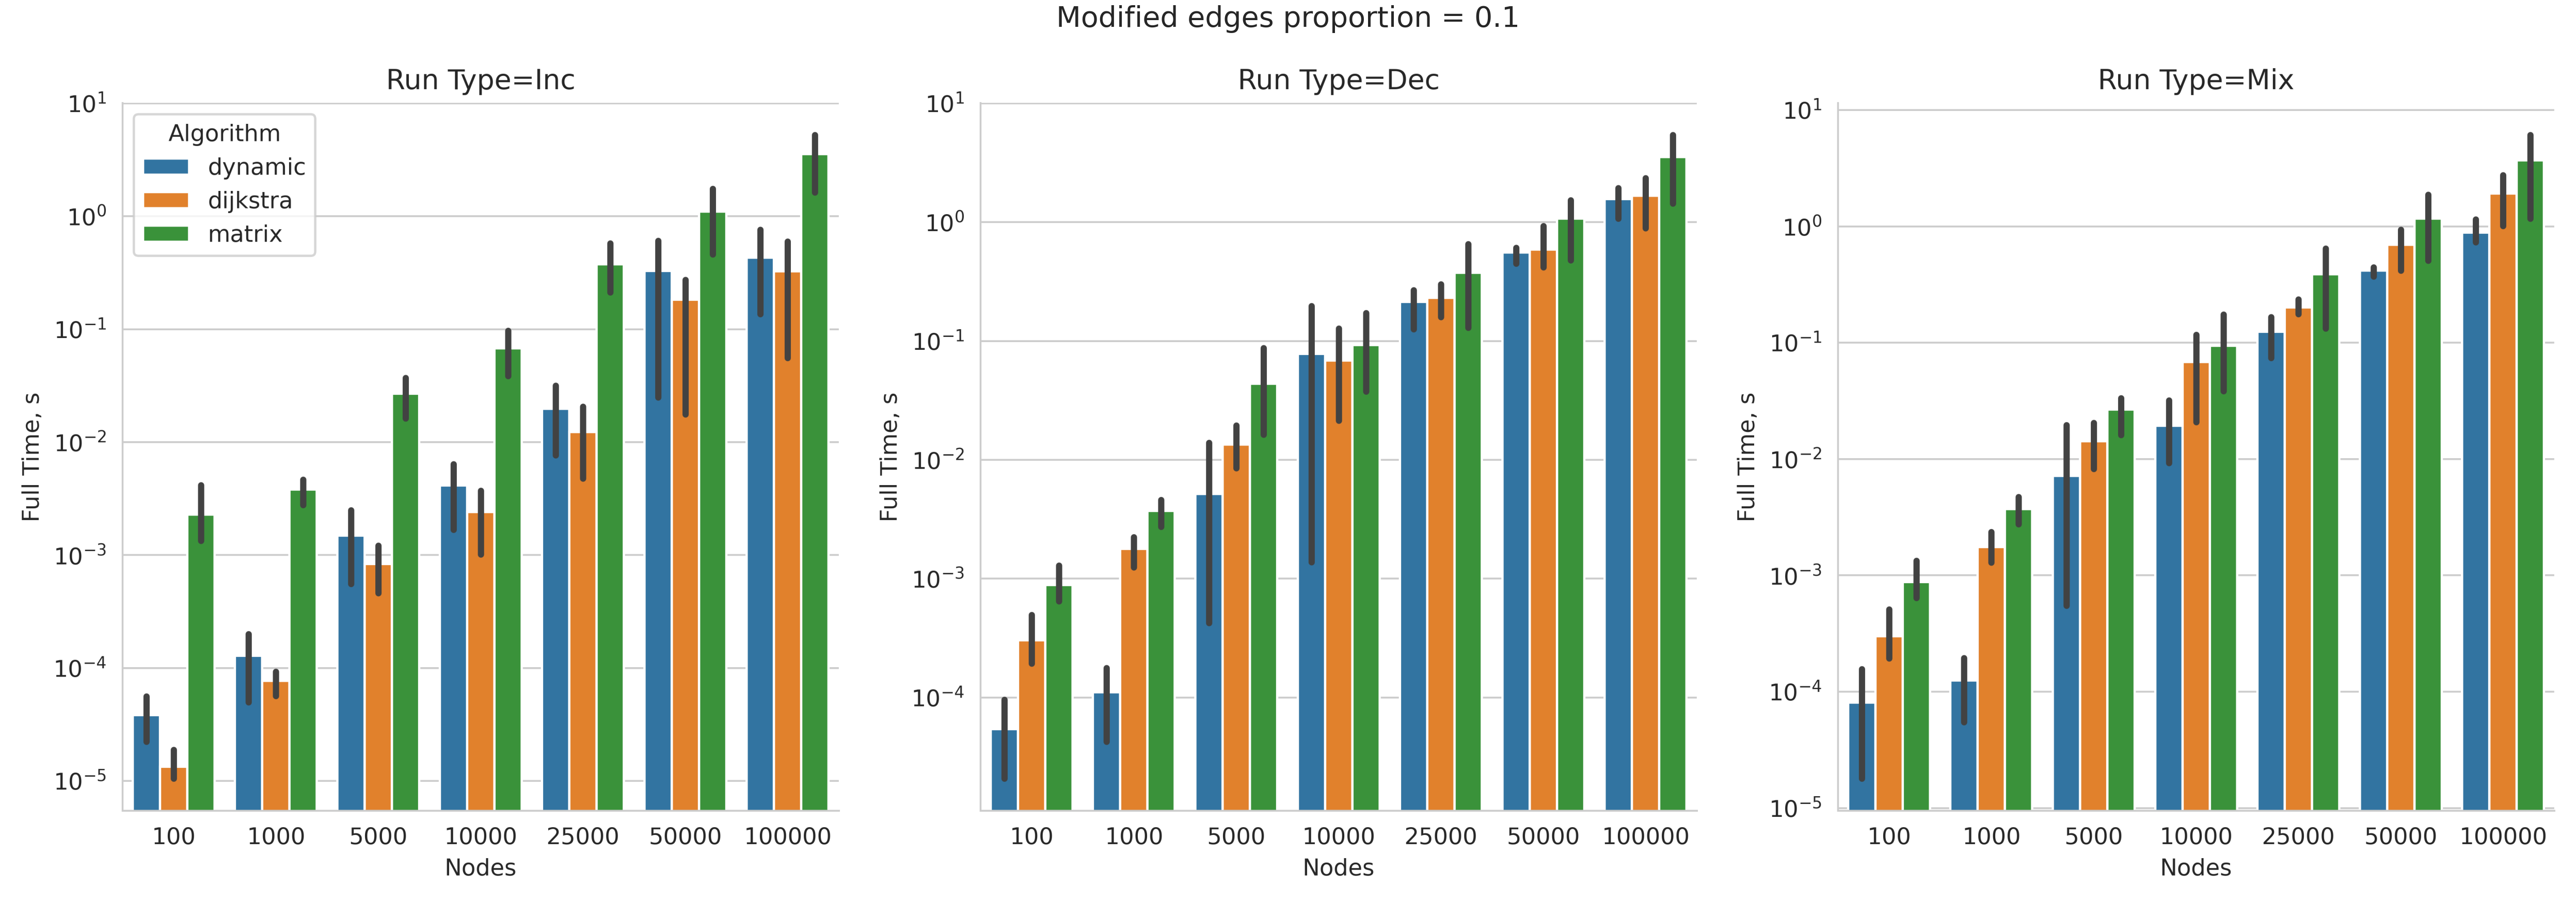

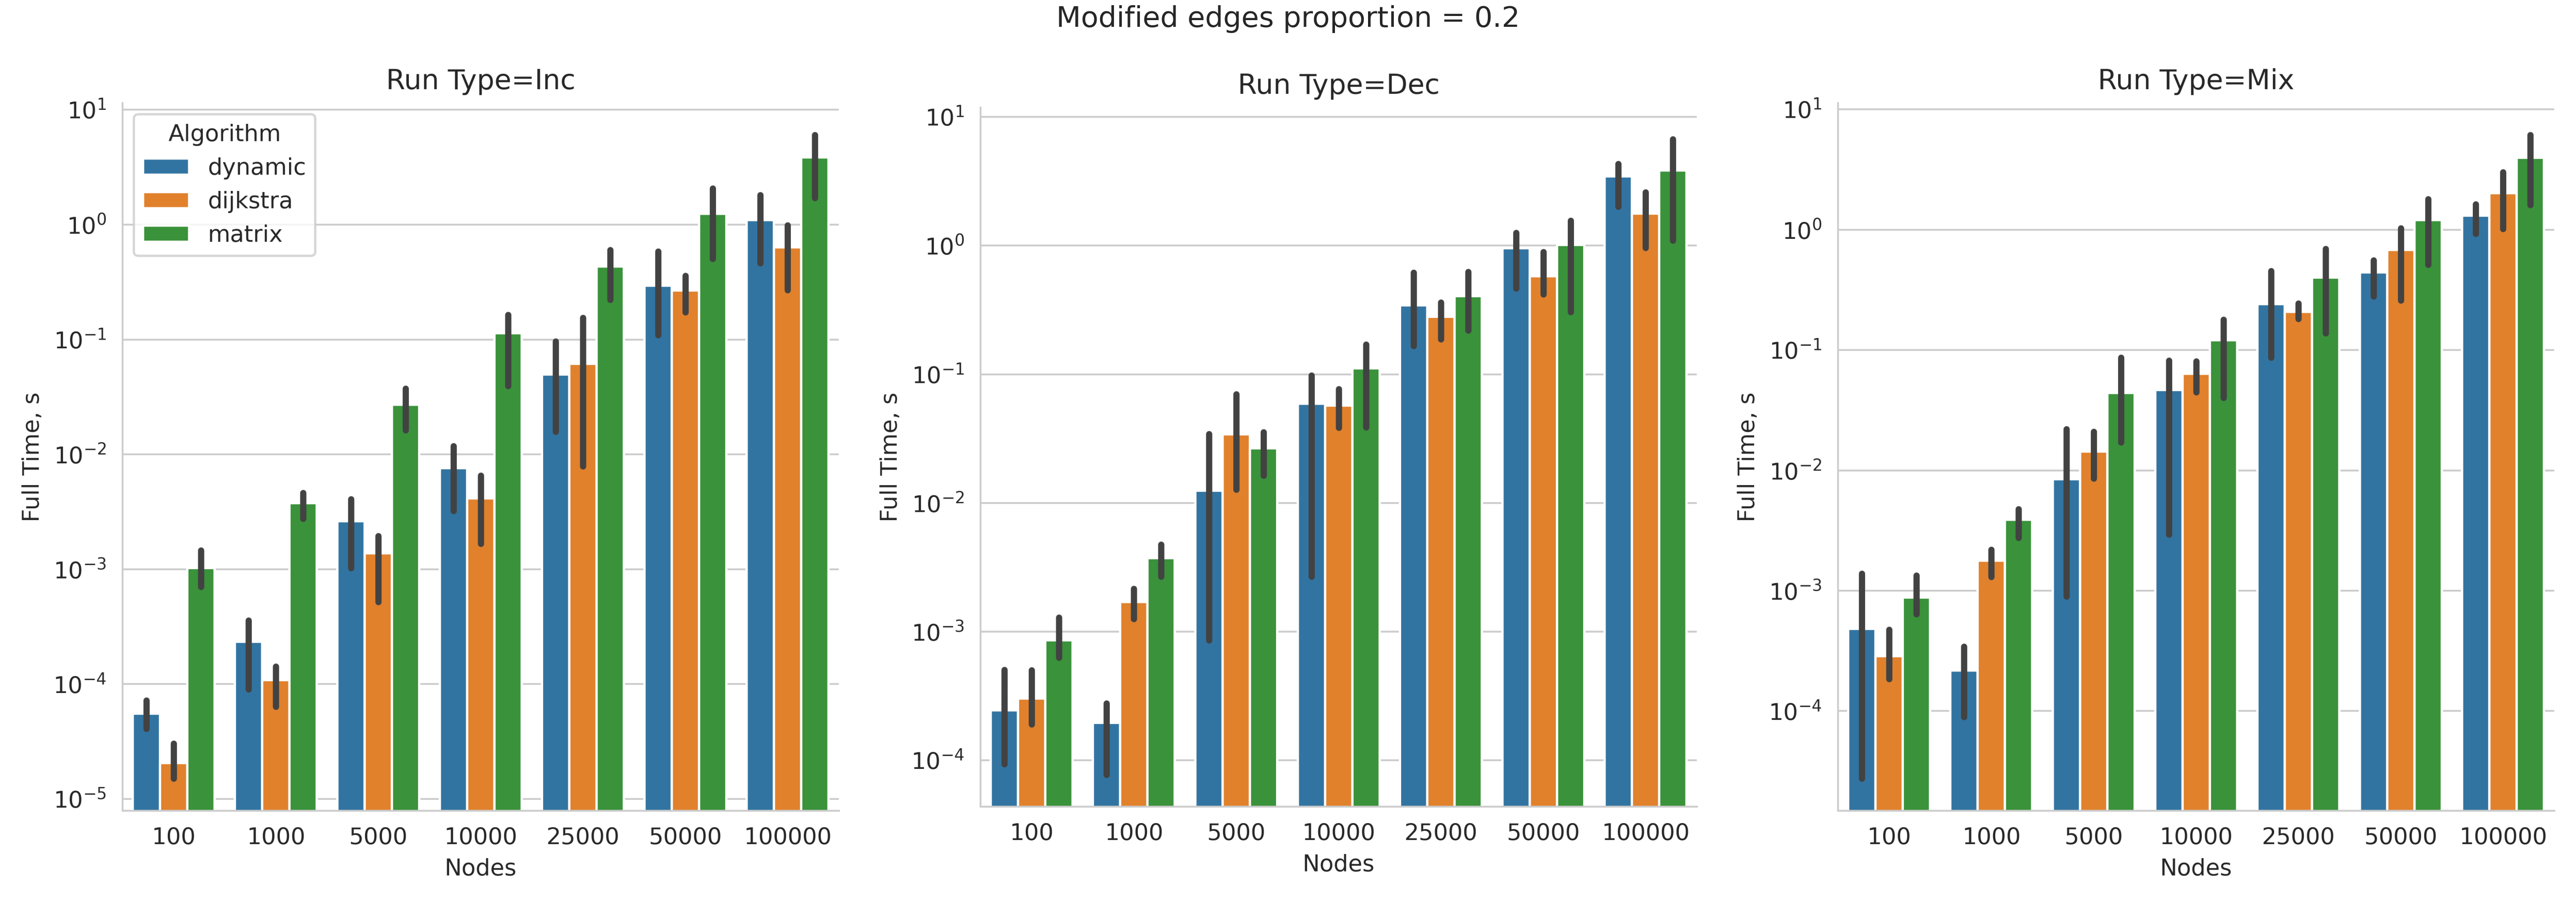

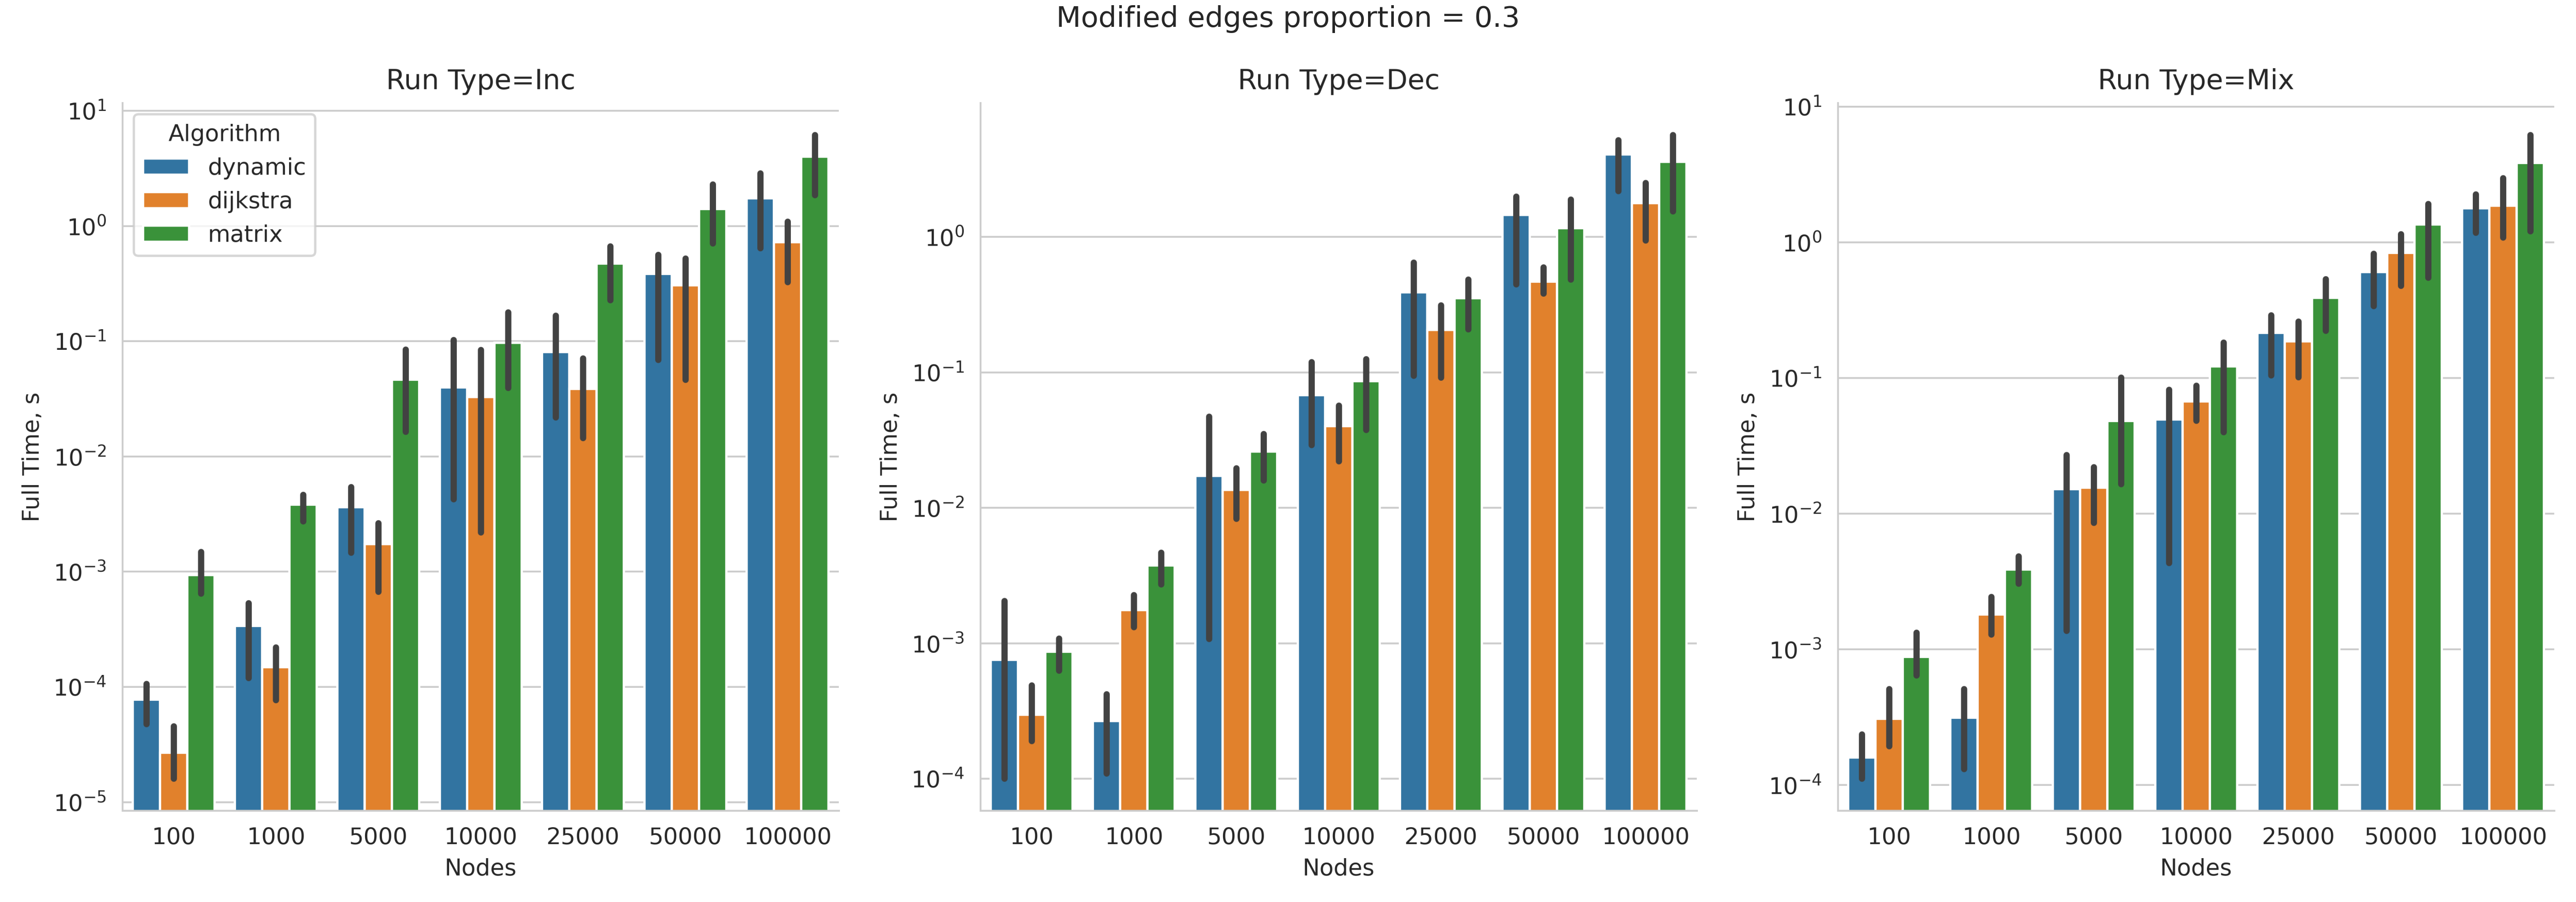

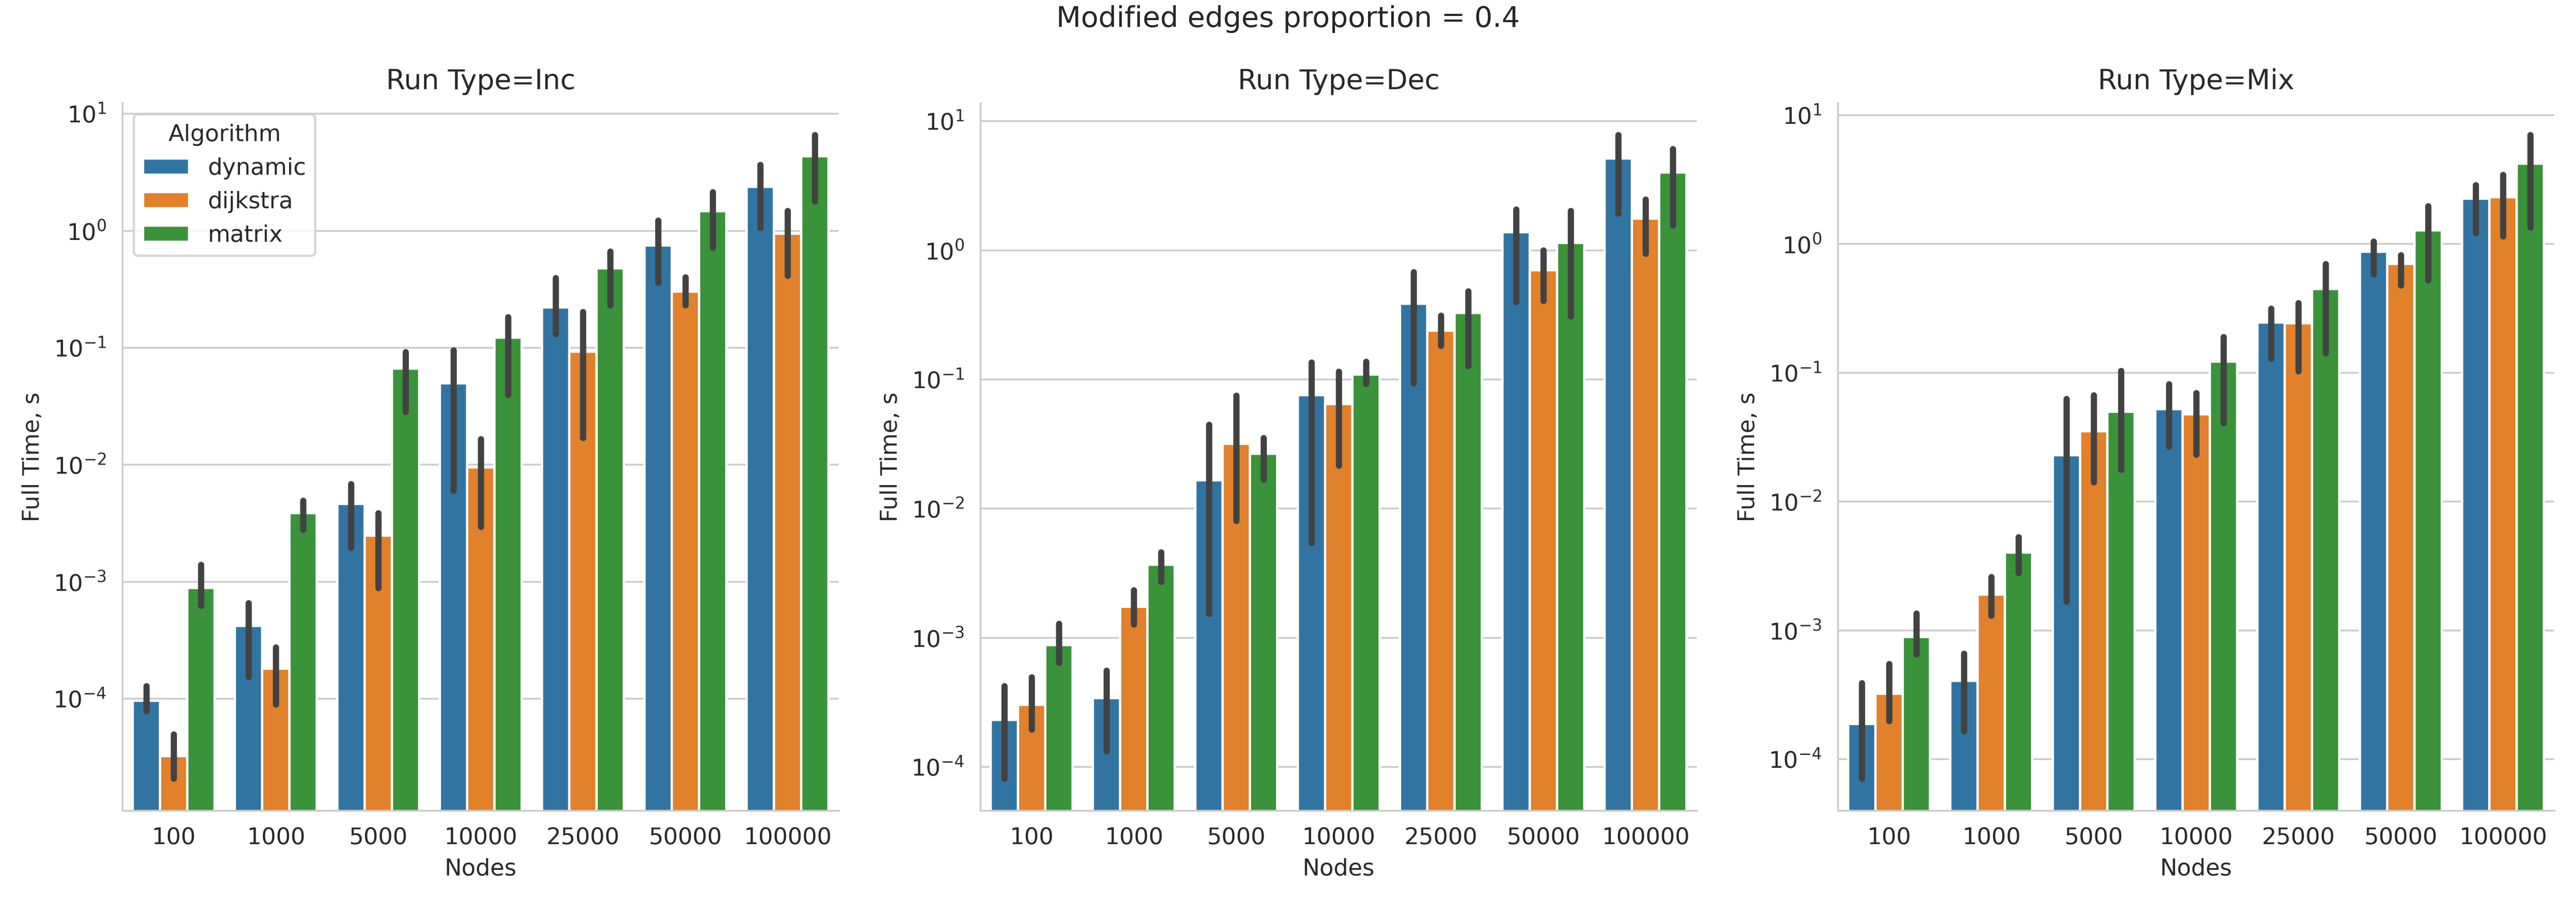

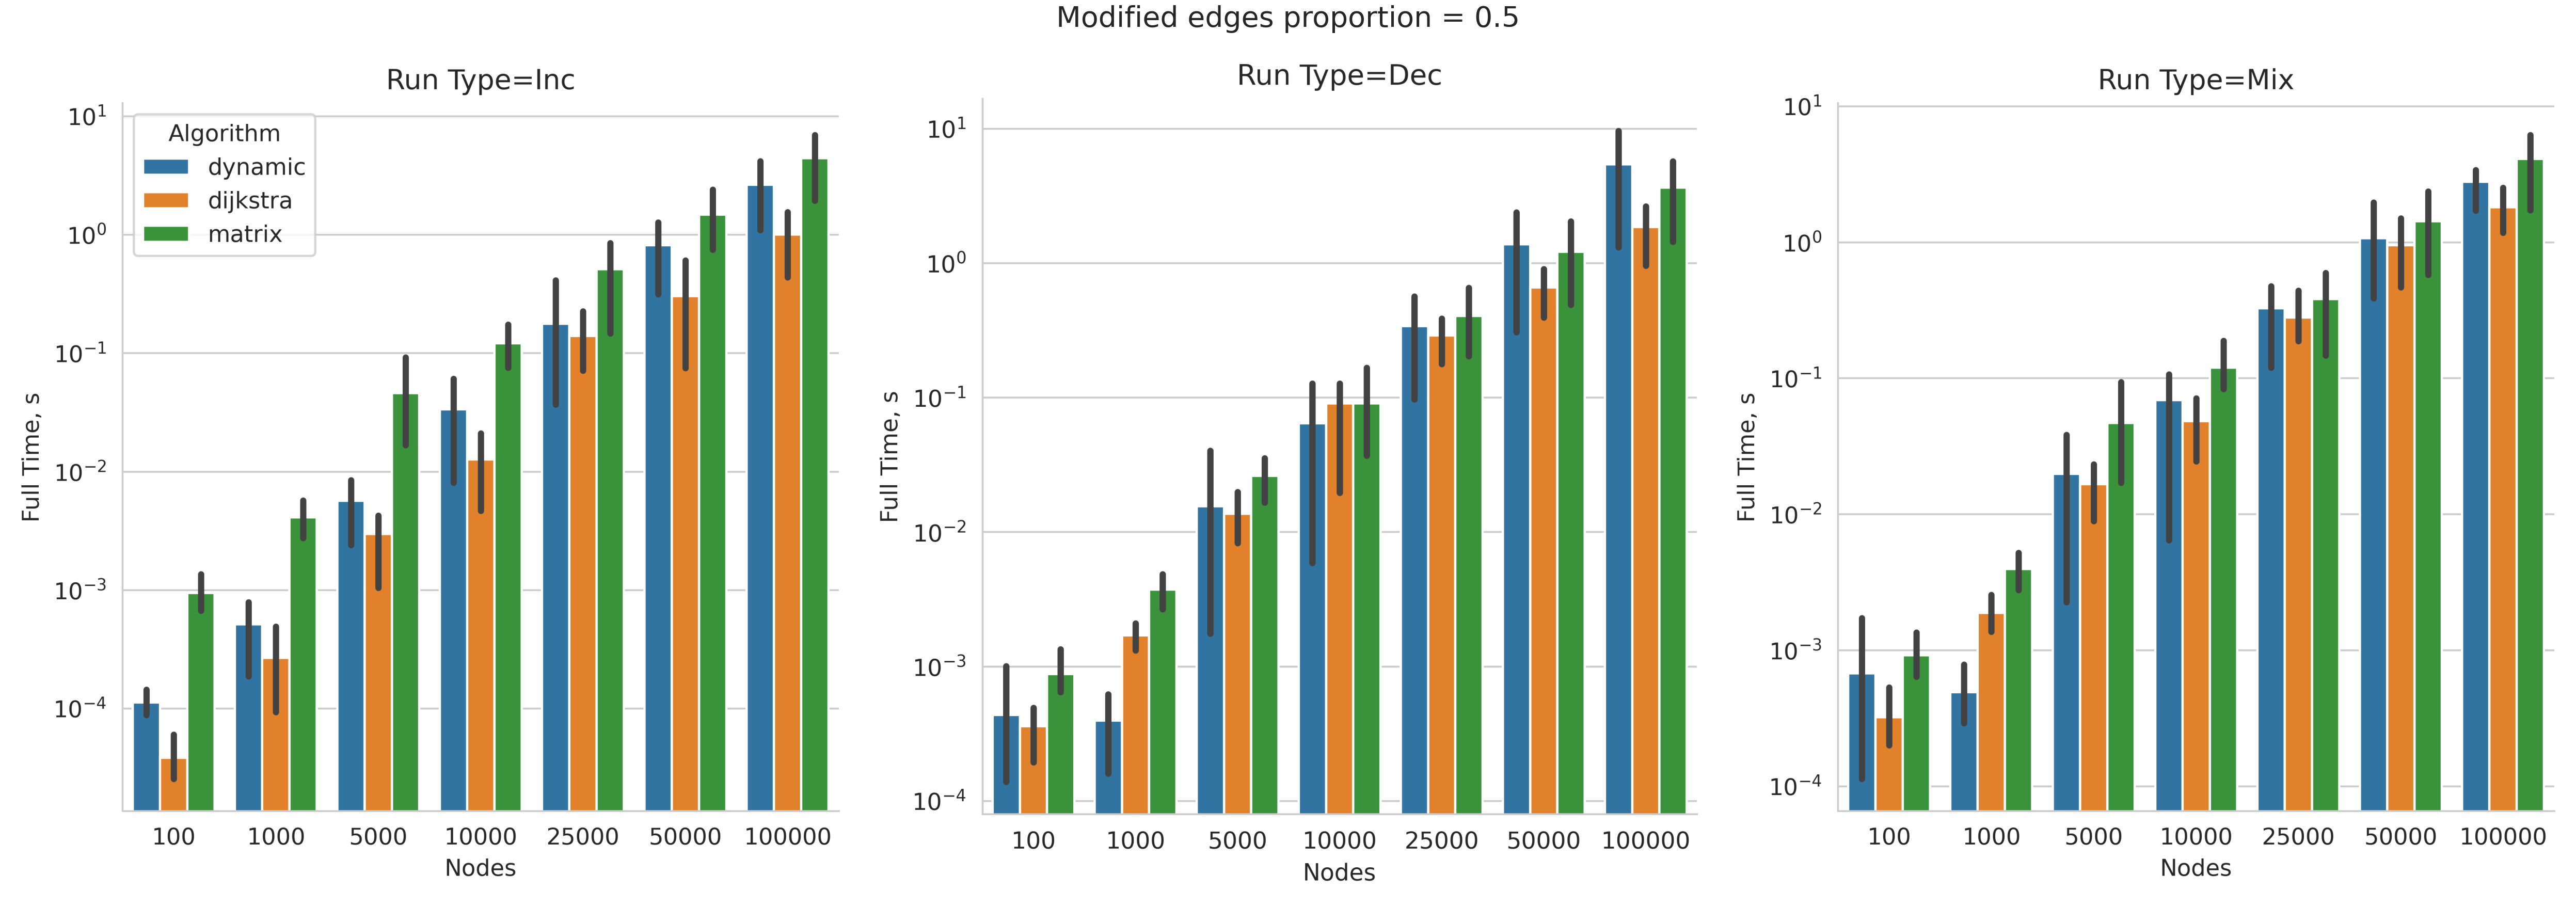

In [14]:
for prop in modified_proportions:
    plots = []
    for run_type in run_types:
        filtered_df = results[
            np.logical_and(results["Run type"] == run_type, results["Modified edges proportion"] == prop)]
        plot = sns.catplot(
            data=filtered_df,
            x="Nodes",
            y="Full Time, s",
            hue="Algorithm",
            kind='bar',
            legend=run_type==run_types[0],
            legend_out=False,
        )
        plt.title(f"Run Type={run_type}")
        plt.yscale("log")
        plots.append(to_image(plot))
        plt.close()

    fig, axs = plt.subplots(ncols=3, figsize=(50, 25))
    for ax, plot in zip(axs, plots):
        ax.imshow(plot)
        ax.axis("off")
    fig.set_tight_layout(True)
    fig.suptitle(f"Modified edges proportion = {prop}", y=0.85, size=40)

#### Algo Time
- Algo Time = время подсчета путей.

В отличие от предыдущего замера у динамического алгоритма нет затрат времени на обновления, значит больше возможности себя проявить (но он все равно плох)

#### Наблюдения
1. Теперь почти всегда хуже динамический. В прошлом замере время алгоритма Bellman–Ford включало преобразование из Digraph в матрицу, что занимало много времени.
2. Тут как бы нечего сказать свыше предыдущего, кроме того, что динамический все равно работает слишком долго.

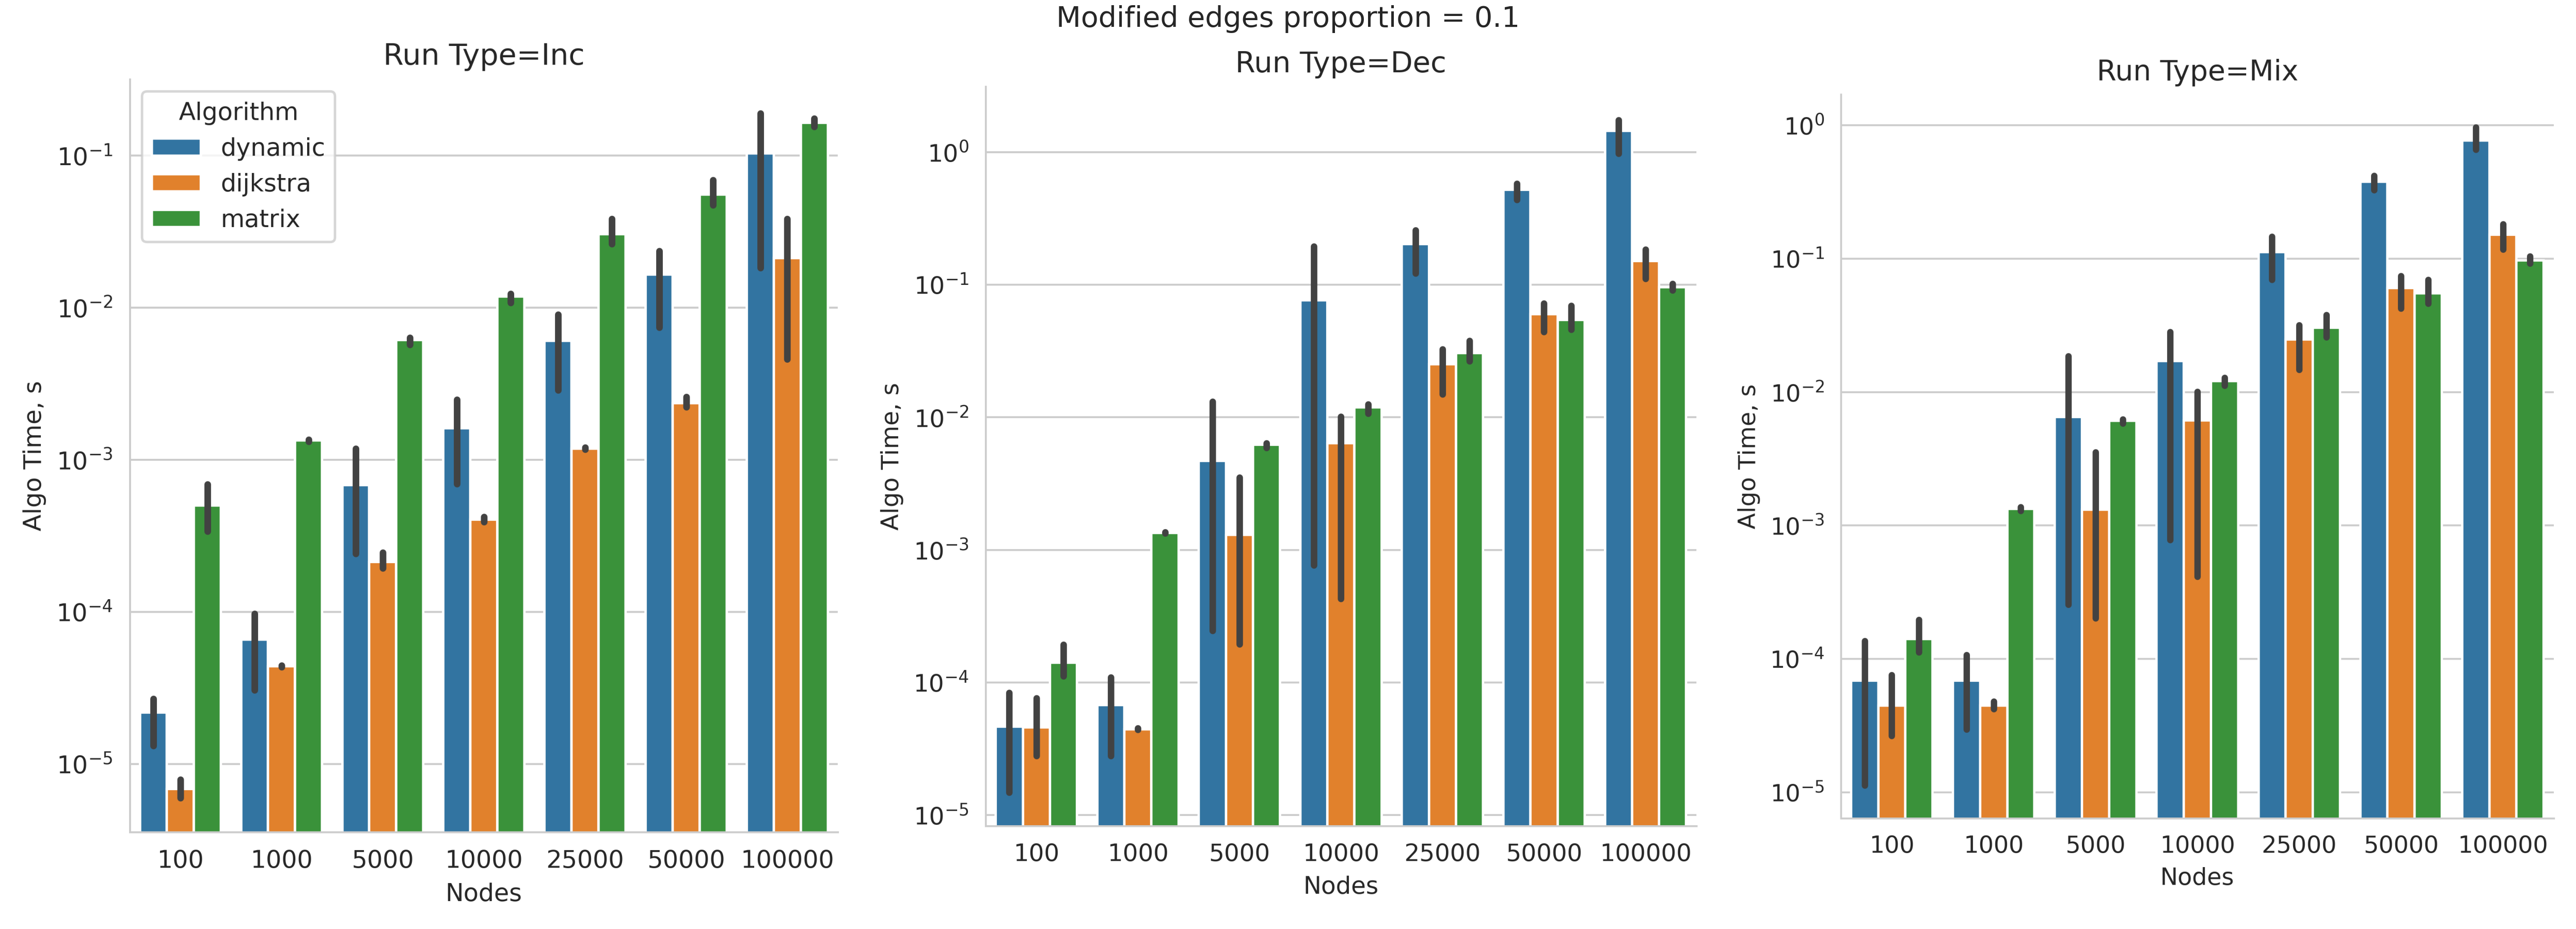

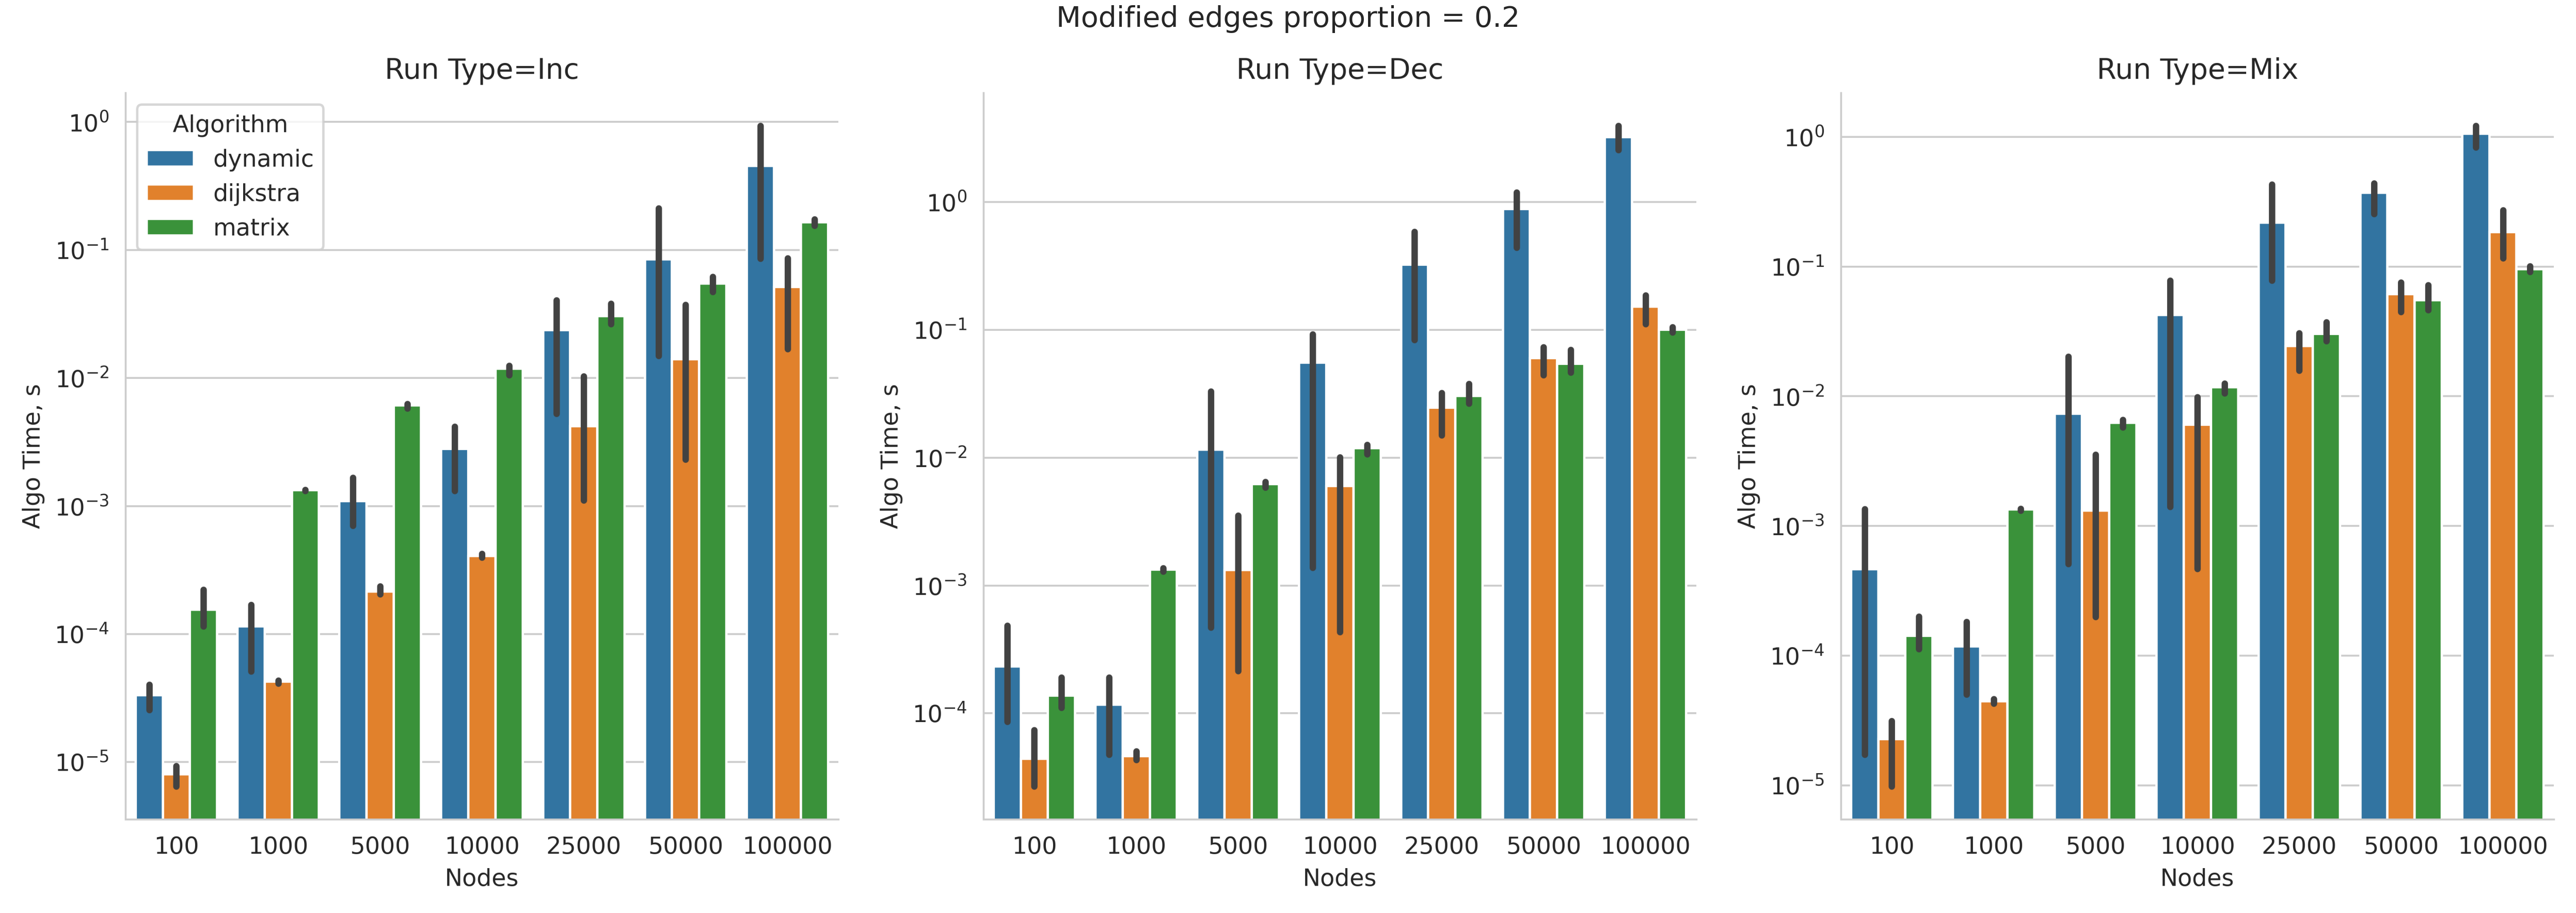

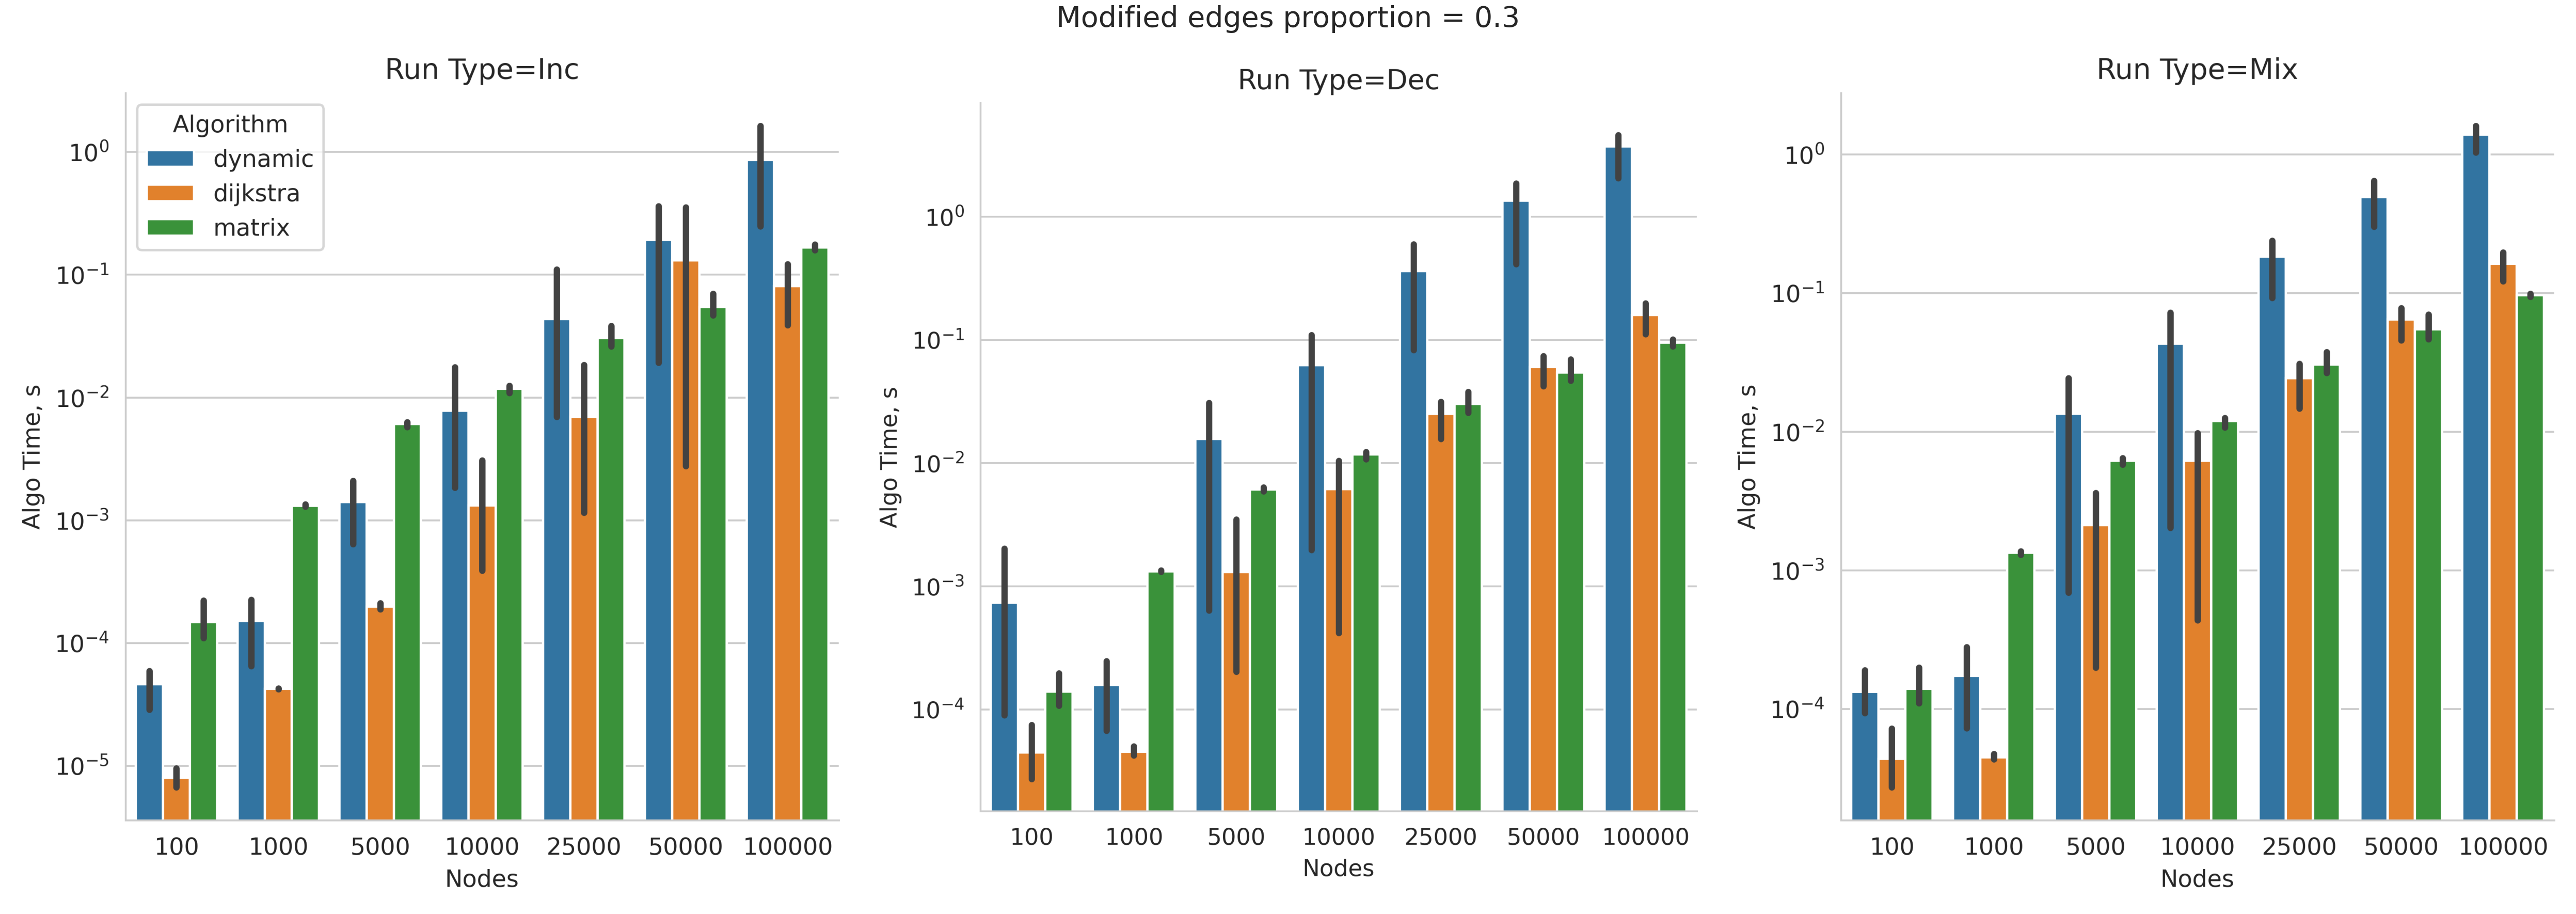

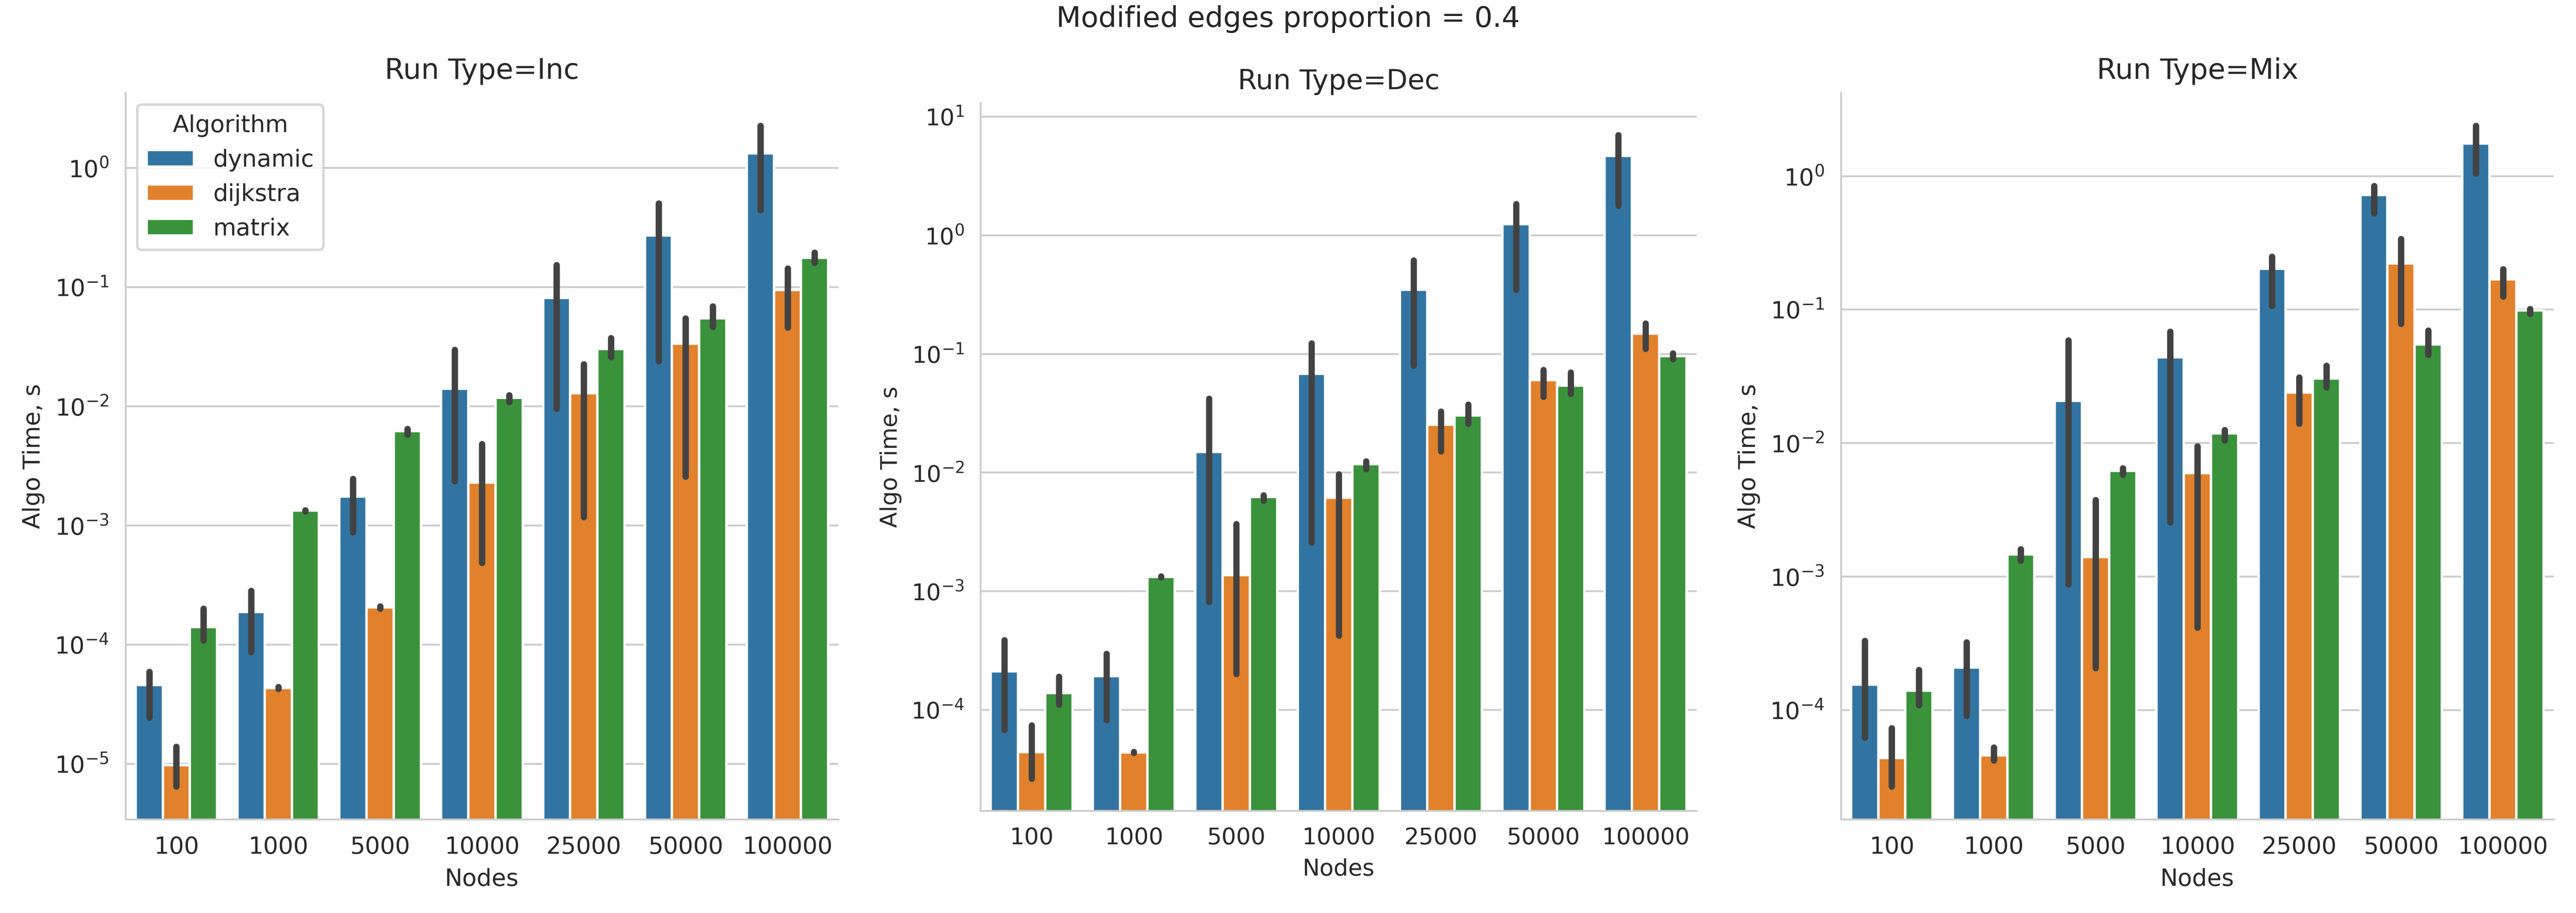

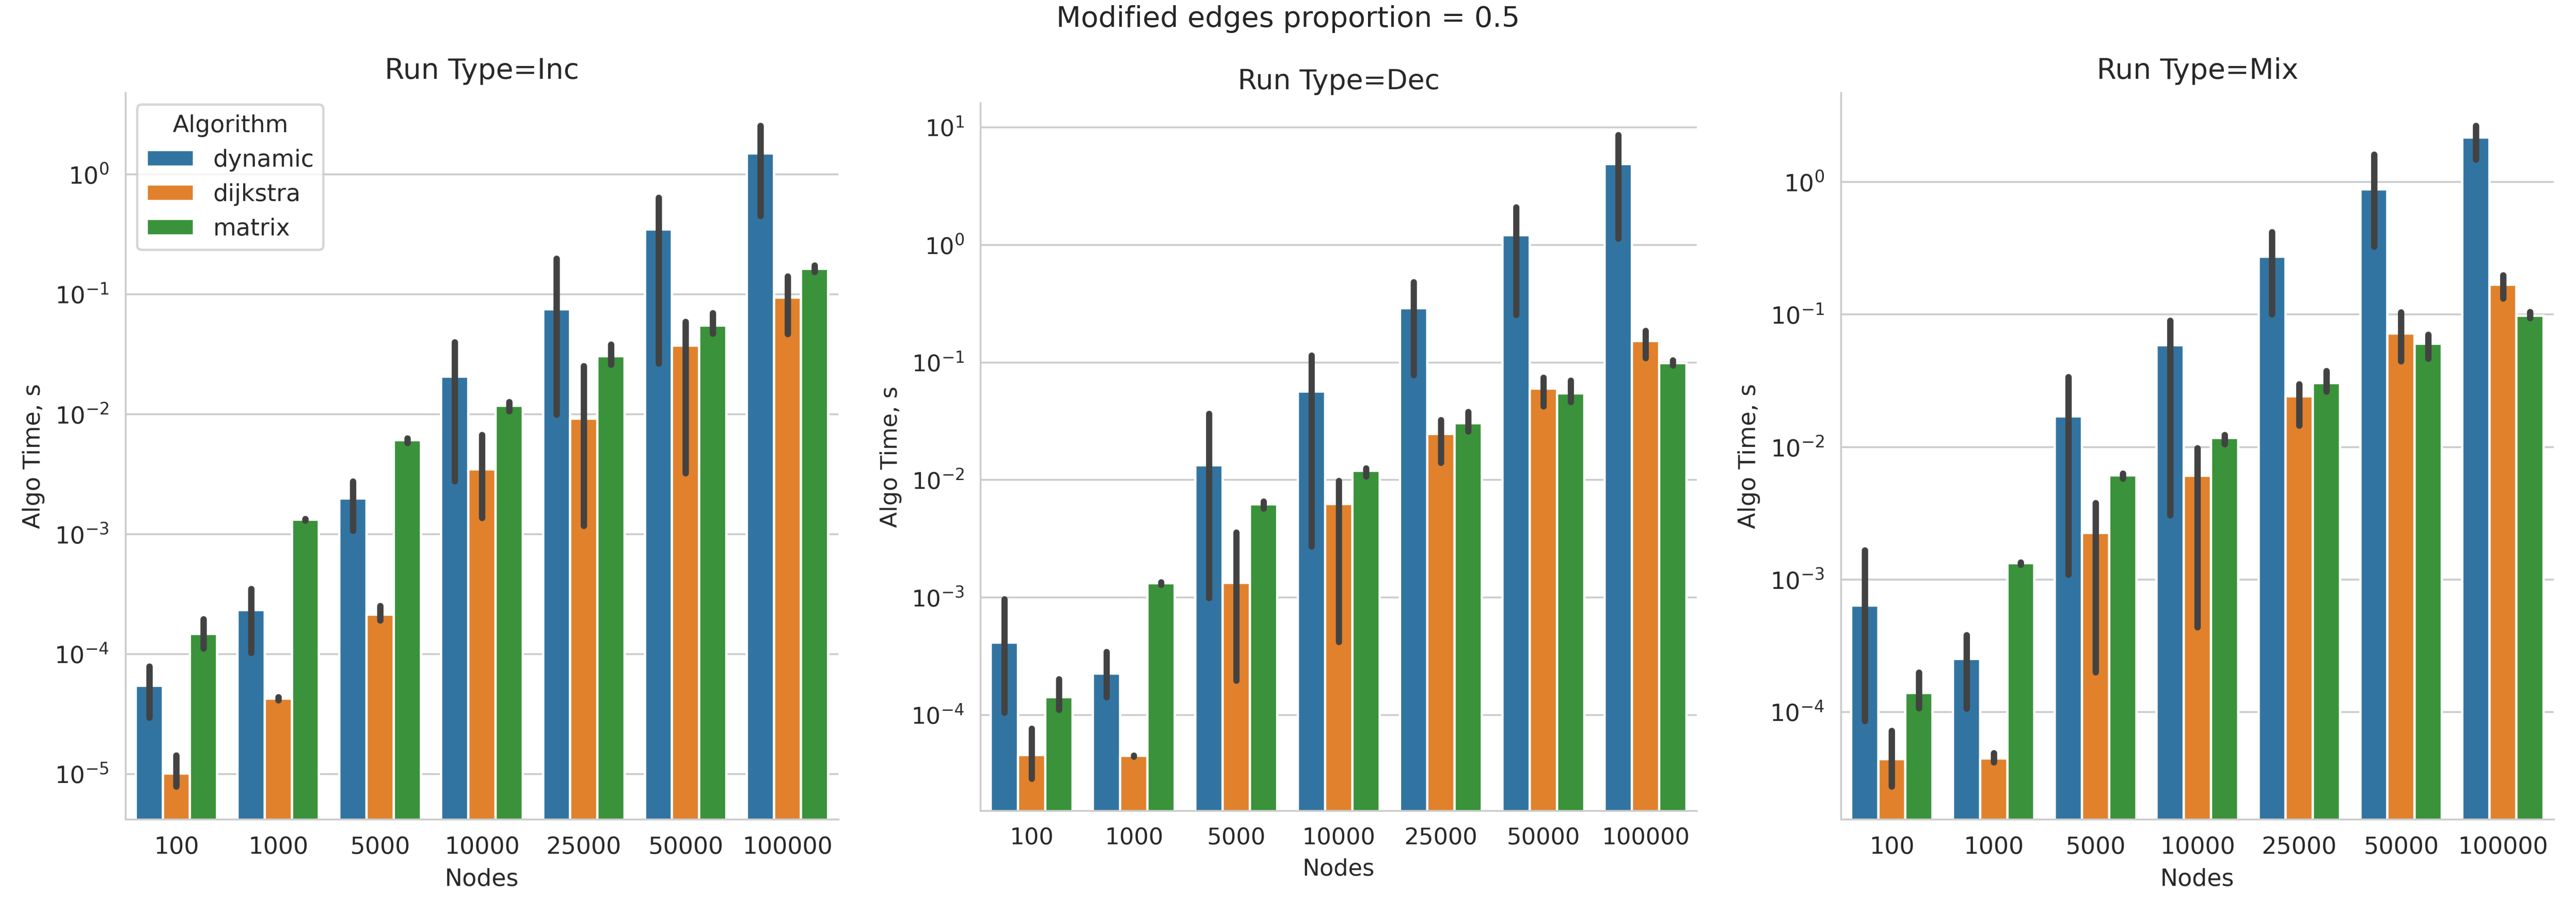

In [15]:
for prop in modified_proportions:
    plots = []
    for run_type in run_types:
        filtered_df = results[
            np.logical_and(results["Run type"] == run_type, results["Modified edges proportion"] == prop)]
        plot = sns.catplot(
            data=filtered_df,
            x="Nodes",
            y="Algo Time, s",
            hue="Algorithm",
            kind='bar',
            legend=run_type == run_types[0],
            legend_out=False,
        )
        plt.title(f"Run Type={run_type}")
        plt.yscale("log")
        plots.append(to_image(plot))
        plt.close()

    fig, axs = plt.subplots(ncols=3, figsize=(50,25))
    for ax, plot in zip(axs, plots):
        ax.imshow(plot)
        ax.axis("off")
    fig.set_tight_layout(True)
    fig.suptitle(f"Modified edges proportion = {prop}", y=0.85, size=40)

## Глубокомысленные ПРОМЕЖУТОЧНЫЕ выводы
Почему же динамический алгоритм работает так плохо...?
Очевидно, потому что он не подходит под текущее задание. В графах для хоть какой-нибудь связанности, я генерировала много ребер (по таблице видно, что их количество может превышать миллион, тогда количество изменяемых ребер свыше 100_000). При большом количестве изменений в динамике приходится много пересчитывать, и это не очень эффективно выходит.

In [11]:
print("Глубоко🤔")

Глубоко🤔


## Эксперимент 2

Давайте попробуем еще раз, но процент будем брать не от ребер, а от вершин например. Таким образом мы сильно умением количество изменений (+ это позволит не сильно переписывать код).

In [24]:
# выбирает ребра от количества вершин
def select_edges(g: nx.DiGraph, edges_part: float):
    k = min(int(g.number_of_nodes() * edges_part), g.number_of_edges() - 1)
    return random.sample(list(g.edges), k=k)


# придумывает новые
def imagine_edges(g: nx.DiGraph, edges_part: float):
    k = int(g.number_of_nodes() * edges_part)
    sources = random.choices(list(g.nodes), k=k)
    targets = random.choices(list(g.nodes), k=k)
    return [[sources[i], targets[i]] for i in range(k)]

In [ ]:
experiments()

### Графики
Тут уже картина поинтереснее
#### Наблюдения
1. При самом маленьком количестве измененных ребер динамика наконец-то начинает выигрывать у статического. Но уже на следующем значении статический алгоритм выигрывает.

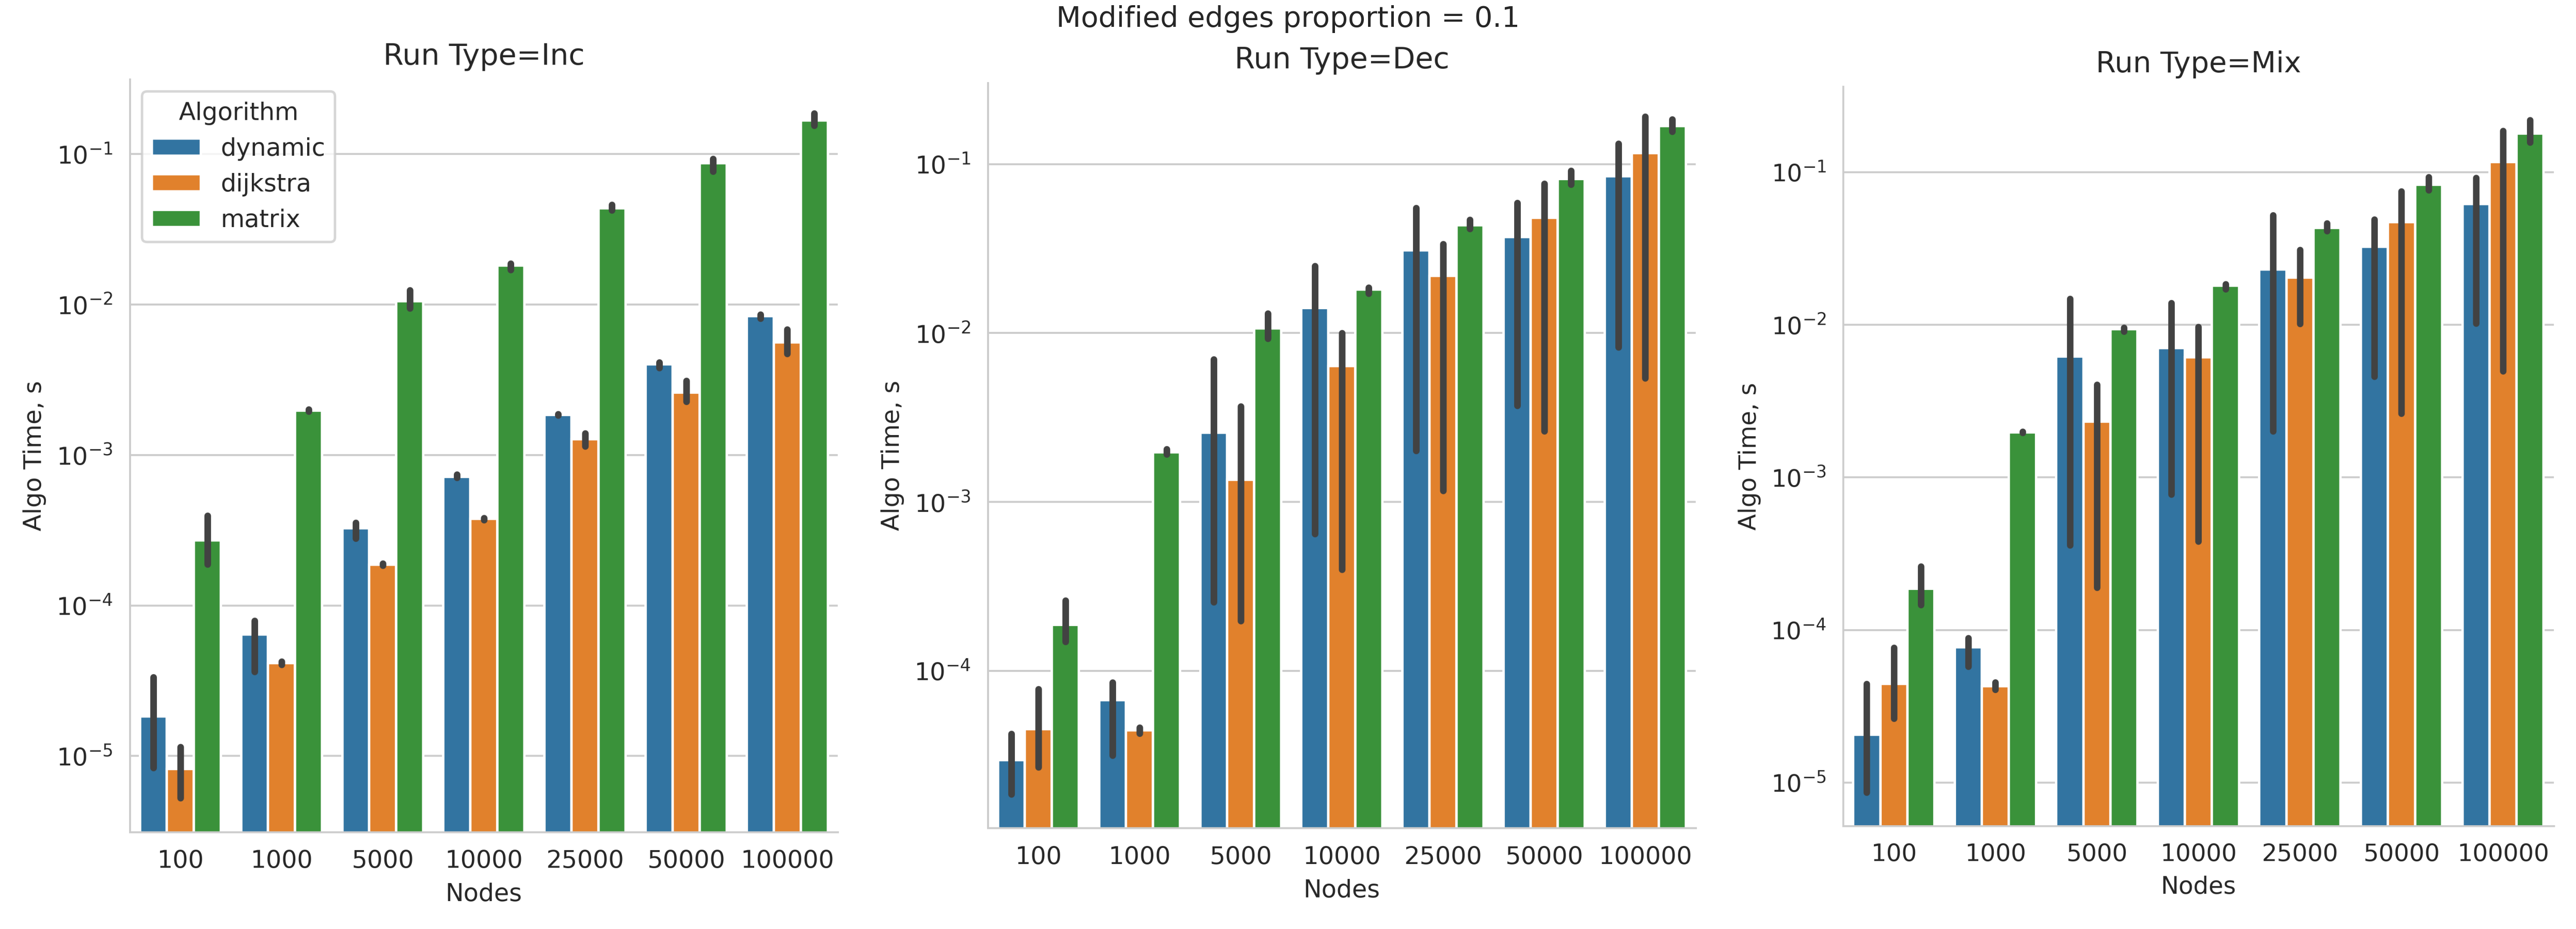

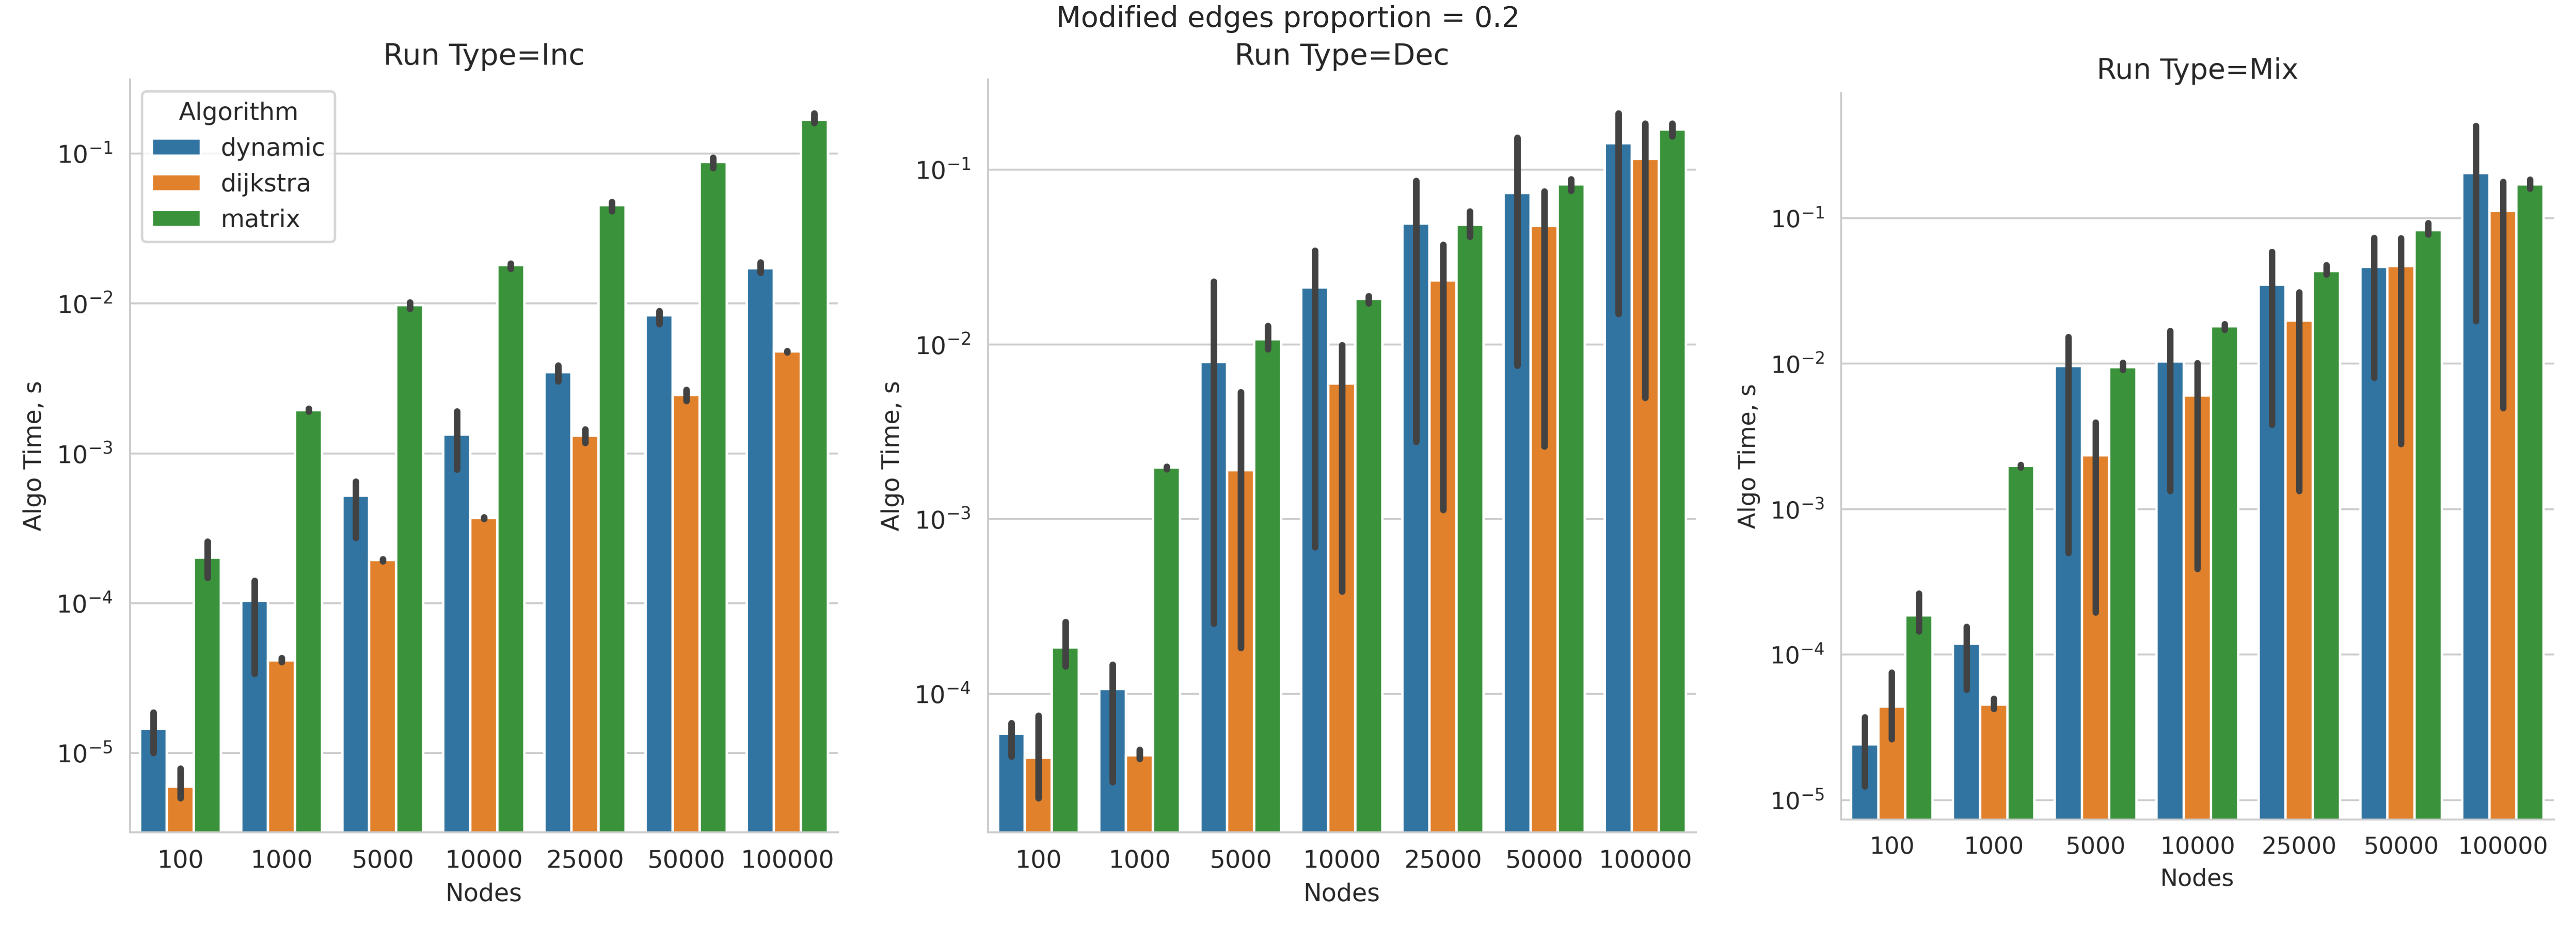

In [29]:
results = pd.read_csv('results5.csv', names=["Run type", "Modified edges proportion", "Algorithm", "Nodes", "Edges", "Full Time, s",
                                            "Algo Time, s"])
for prop in modified_proportions[0:2]:
    plots = []
    for run_type in run_types:
        filtered_df = results[
            np.logical_and(results["Run type"] == run_type, results["Modified edges proportion"] == prop)]
        plot = sns.catplot(
            data=filtered_df,
            x="Nodes",
            y="Algo Time, s",
            hue="Algorithm",
            kind='bar',
            legend=run_type == run_types[0],
            legend_out=False,
        )
        plt.title(f"Run Type={run_type}")
        plt.yscale("log")
        plots.append(to_image(plot))
        plt.close()

    fig, axs = plt.subplots(ncols=3, figsize=(50,25))
    for ax, plot in zip(axs, plots):
        ax.imshow(plot)
        ax.axis("off")
    fig.set_tight_layout(True)
    fig.suptitle(f"Modified edges proportion = {prop}", y=0.85, size=40)

## Глубокомысленные выводы
1. Чем меньше измененных ребер, тем меньше времени тратиться на подсчет путей в динамике (это обусловленною тем, что мы пересчитываем для меньшего количества вершин).
2. Алгоритм с матрицами довольно долгий, особенно когда храним граф не в матрице, а в другом представлении.
3. В данных условиях динамика показала себя не в самом лучшем свете, в большинстве случаем статический Дейкстры работает быстрее.


Еще не хватает эксперимента, где будет несколько подсчетов путей при маленьком количестве обновлений между запросами. В теории тогда динамика покажет себя лучше.

Возможно еще дело в сильно связанности, если будет много раздельных компонент, то динамика тоже должна лучше себя показать. Так как мы видим при маленьких графах динамика показывает себя лучше.

Так что для более качественного исследования много чего не хватает. (Для домашки с конкретными требованиями все сделано + дополнительный замер с меньшим количеством обновлений)